In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [2]:
# =========================
# Load data
aug_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/augmented_training_data.csv")
aug_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/augmented_testing_data.csv")
org_train = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Training/orignal_training_data.csv")
org_test = pd.read_csv("/Users/Harshit_Professional/Desktop/projects/wind_forecasting/Data/Testing/orignal_testing_data.csv")

In [3]:

# Convert Timestamp columns to datetime (very important for time operations)
for df in [aug_train, aug_test, org_train, org_test]:
    df['Timestamp'] = pd.to_datetime(df['Time'])

In [4]:
# =========================
# Lag + Rolling Feature Engineering

def generate_lag_and_rolling_features(df, lags_dict, rolling_windows):
    df = df.copy()
    all_groups = []
    
    for loc, group in df.groupby('Location'):
        group = group.sort_values('Timestamp')  # time sort within location
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged

# =========================
# Lag + Rolling Feature Engineering (Timestamp → AugType → Location sorting)

def generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows):
    df = df.copy()
    
    # First sort globally by Timestamp, AugmentationType, then Location
    df = df.sort_values(['Timestamp', 'augmented', 'Location']).reset_index(drop=True)
    
    all_groups = []
    
    # Group by (AugmentationType, Location) — after global sorting
    for (aug_type, loc), group in df.groupby(['augmented', 'Location']):
        group = group.sort_values('Timestamp')  # ensure strict time order within each subgroup
        
        # Generate Lags
        for col, lags in lags_dict.items():
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
                
        # Rolling Features
        for window in rolling_windows:
            for col in lags_dict.keys():
                group[f"{col}_roll_mean_{window}"] = group[col].rolling(window).mean()
                group[f"{col}_roll_std_{window}"] = group[col].rolling(window).std()
        
        all_groups.append(group)
    
    df_lagged = pd.concat(all_groups).reset_index(drop=True)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged




def add_time_features(df):
    df = df.copy()
    df['hour'] = df['Timestamp'].dt.hour
    df['month'] = df['Timestamp'].dt.month
    
    df['hour_sin']  = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos']  = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    return df

def scale_features(df, scaler=None, feature_cols=None):
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(df[feature_cols])
    else:
        scaled_values = scaler.transform(df[feature_cols])

    df_scaled = df.copy()
    df_scaled[feature_cols] = scaled_values
    return df_scaled, scaler

In [5]:
# =========================
# Complete Pipeline Function

def full_preprocessing_pipeline(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

# =========================
# Complete Pipeline Function for augmented data

def full_preprocessing_pipeline_for_aug(df, lags_dict, rolling_windows, scale_data=True):
    df = generate_lag_and_rolling_features_for_aug(df, lags_dict, rolling_windows)
    df = add_time_features(df)
    
    # Collect feature columns for scaling
    features_to_scale = []
    for col in lags_dict.keys():
        features_to_scale.append(col)
        for lag in lags_dict[col]:
            features_to_scale.append(f"{col}_lag{lag}")
        for window in rolling_windows:
            features_to_scale.append(f"{col}_roll_mean_{window}")
            features_to_scale.append(f"{col}_roll_std_{window}")
    features_to_scale += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']
    
    scaler = None
    if scale_data:
        df, scaler = scale_features(df, scaler=None, feature_cols=features_to_scale)
    
    return df, scaler

In [6]:
# =========================
# Setup lags and rolling windows

lags_dict = {
    'Power': [1, 3, 6, 12, 24],
    'windspeed_10m': [1, 3, 6, 24],
    'windspeed_100m': [1, 3, 6, 24],
    'windgusts_10m': [1, 3, 6, 24],
}

rolling_windows = [3, 6, 12, 24]

# =========================
# Apply pipeline

# ORIGINAL DATA
org_train_processed, org_scaler = full_preprocessing_pipeline(org_train, lags_dict, rolling_windows)
org_test_processed, _           = full_preprocessing_pipeline(org_test, lags_dict, rolling_windows)

# AUGMENTED DATA
aug_train_processed, aug_scaler = full_preprocessing_pipeline_for_aug(aug_train, lags_dict, rolling_windows)
# aug_test_processed, _           = full_preprocessing_pipeline_for_aug(aug_test, lags_dict, rolling_windows)

print("All datasets processed successfully!")


All datasets processed successfully!


In [7]:
# Parse timestamp if not already done
org_test['Timestamp'] = pd.to_datetime(org_test['Time'])

# Features and target
features = [
       'windspeed_10m', 'windspeed_100m', 'winddirection_10m',
       'winddirection_100m', 'windgusts_10m', 'Power_lag1', 'Power_lag3',
       'Power_lag6', 'Power_lag12', 'Power_lag24', 'windspeed_10m_lag1',
       'windspeed_10m_lag3', 'windspeed_10m_lag6', 'windspeed_10m_lag24',
       'windspeed_100m_lag1', 'windspeed_100m_lag3', 'windspeed_100m_lag6',
       'windspeed_100m_lag24', 'windgusts_10m_lag1', 'windgusts_10m_lag3',
       'windgusts_10m_lag6', 'windgusts_10m_lag24', 'Power_roll_mean_3',
       'Power_roll_std_3', 'windspeed_10m_roll_mean_3',
       'windspeed_10m_roll_std_3', 'windspeed_100m_roll_mean_3',
       'windspeed_100m_roll_std_3', 'windgusts_10m_roll_mean_3',
       'windgusts_10m_roll_std_3', 'Power_roll_mean_6', 'Power_roll_std_6',
       'windspeed_10m_roll_mean_6', 'windspeed_10m_roll_std_6',
       'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6',
       'windgusts_10m_roll_mean_6', 'windgusts_10m_roll_std_6',
       'Power_roll_mean_12', 'Power_roll_std_12', 'windspeed_10m_roll_mean_12',
       'windspeed_10m_roll_std_12', 'windspeed_100m_roll_mean_12',
       'windspeed_100m_roll_std_12', 'windgusts_10m_roll_mean_12',
       'windgusts_10m_roll_std_12', 'Power_roll_mean_24', 'Power_roll_std_24',
       'windspeed_10m_roll_mean_24', 'windspeed_10m_roll_std_24',
       'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24',
       'windgusts_10m_roll_mean_24', 'windgusts_10m_roll_std_24'
]
target = 'Power'

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

In [9]:

# ------------------ PatchTST Model ------------------
class PatchTST(nn.Module):
    def __init__(self, seq_len, n_features, patch_len, forecast_horizon, d_model=128, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.patch_len = patch_len
        self.n_patches = seq_len // patch_len
        self.d_model = d_model

        self.patch_embed = nn.Linear(patch_len * n_features, d_model)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.n_patches, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, forecast_horizon)

    def forward(self, x):
        B = x.shape[0]
        x = x.unfold(dimension=1, size=self.patch_len, step=self.patch_len)  
        x = x.contiguous().view(B, self.n_patches, -1)
        x = self.patch_embed(x)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x.mean(dim=1)
        out = self.output_layer(x)
        return out


In [10]:
# ------------------ Dataset Preparation ------------------
def create_sequences(X_data, y_data, seq_len, forecast_horizon):
    X_seq, y_seq = [], []
    for i in range(len(X_data) - seq_len - forecast_horizon):
        X_seq.append(X_data.iloc[i:i+seq_len].values)
        y_seq.append(y_data.iloc[i+seq_len:i+seq_len+forecast_horizon].values)
    return np.array(X_seq), np.array(y_seq)

# ------------------ Desequencing Function ------------------
def desequence(predictions, seq_len, forecast_horizon):
    total_length = len(predictions) + seq_len + forecast_horizon - 1
    merged_forecast = np.zeros(total_length)
    count = np.zeros(total_length)

    for i in range(len(predictions)):
        start_idx = i + seq_len
        end_idx = start_idx + forecast_horizon
        merged_forecast[start_idx:end_idx] += predictions[i]
        count[start_idx:end_idx] += 1

    nonzero_mask = count != 0
    merged_forecast[nonzero_mask] /= count[nonzero_mask]

    return merged_forecast

In [11]:
seq_len = 24
forecast_horizon = 12
patch_len = 4

X_train_org = org_train_processed[features]
y_train_org = org_train_processed[target]

X_train_aug = aug_train_processed[features]
y_train_aug = aug_train_processed[target]

X_test = org_test_processed[features]
y_test = org_test_processed[target]

In [12]:
# ------------------ Updated Evaluation Function ------------------
def evaluate_two_models(
    model_orig, model_aug, scaler, X_test, y_test, features, 
    seq_len, forecast_horizon, patch_len, time_index=None, 
    start_point=0, end_point=None
):
    # Scale test data
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)
    X_seq, y_seq = create_sequences(X_test_scaled, y_test, seq_len, forecast_horizon)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    
    # Get predictions from original model
    model_orig.eval()
    with torch.no_grad():
        preds_orig = model_orig(X_tensor).numpy()
    merged_pred_orig = desequence(preds_orig, seq_len, forecast_horizon)

    # Get predictions from augmented model
    model_aug.eval()
    with torch.no_grad():
        preds_aug = model_aug(X_tensor).numpy()
    merged_pred_aug = desequence(preds_aug, seq_len, forecast_horizon)
    
    # Get true values
    merged_true = desequence(y_seq, seq_len, forecast_horizon)
    
    # Apply slicing
    merged_true = merged_true[start_point:end_point]
    merged_pred_orig = merged_pred_orig[start_point:end_point]
    merged_pred_aug = merged_pred_aug[start_point:end_point]

    # Metrics for both models
    mse_orig = mean_squared_error(merged_true, merged_pred_orig)
    mae_orig = mean_absolute_error(merged_true, merged_pred_orig)
    rmse_orig = math.sqrt(mse_orig)

    mse_aug = mean_squared_error(merged_true, merged_pred_aug)
    mae_aug = mean_absolute_error(merged_true, merged_pred_aug)
    rmse_aug = math.sqrt(mse_aug)

    print(f"Original Model - MSE: {mse_orig:.4f}, MAE: {mae_orig:.4f}, RMSE: {rmse_orig:.4f}")
    print(f"Augmented Model - MSE: {mse_aug:.4f}, MAE: {mae_aug:.4f}, RMSE: {rmse_aug:.4f}")

    if time_index is not None:
        time_index = time_index[-len(merged_true):]
        plot_range = time_index
    else:
        plot_range = range(len(merged_true))

    # Plot
    plt.figure(figsize=(16, 6))
    plt.plot(plot_range, merged_true, label='Actual', color='black', linewidth=2)
    plt.plot(plot_range, merged_pred_orig, label='Original Model Forecast', color='red', linestyle='--')
    plt.plot(plot_range, merged_pred_aug, label='Augmented Model Forecast', color='blue', linestyle=':')

    # Fill area between Actual and Original Model
    plt.fill_between(
        plot_range, merged_true, merged_pred_orig, 
        where=(merged_true > merged_pred_orig), 
        interpolate=True, color='pink', alpha=0.5, label='Error (Actual - Original)'
    )
    plt.fill_between(
        plot_range, merged_pred_orig, merged_true, 
        where=(merged_true <= merged_pred_orig), 
        interpolate=True, color='pink', alpha=0.5
    )

    # Fill area between Original Model and Augmented Model
    plt.fill_between(
        plot_range, merged_pred_orig, merged_pred_aug, 
        where=(merged_pred_aug > merged_pred_orig), 
        interpolate=True, color='lightblue', alpha=0.5, label='Difference (Original - Augmented)'
    )
    plt.fill_between(
        plot_range, merged_pred_aug, merged_pred_orig, 
        where=(merged_pred_aug <= merged_pred_orig), 
        interpolate=True, color='lightblue', alpha=0.5
    )

    plt.xlabel("Date" if time_index is not None else "Steps")
    plt.ylabel("Power")
    plt.title("Forecast Comparison: Original vs Augmented Model")
    plt.legend()
    plt.grid(True)
    
    # Show metrics in plot
    textstr = (
        f'Original Model\nMAE: {mae_orig:.4f}\nRMSE: {rmse_orig:.4f}\n'
        f'Augmented Model\nMAE: {mae_aug:.4f}\nRMSE: {rmse_aug:.4f}'
    )
    plt.gcf().text(0.75, 0.15, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()


In [13]:
import joblib

In [14]:
model_patchtst  =PatchTST(seq_len, len(features), patch_len, forecast_horizon)
# Load model state_dict
model_path  = "../Models/weights/patchtst_model.pth"
model_patchtst.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_patchtst.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [15]:
model_patchtst_aug  =PatchTST(seq_len, len(features), patch_len, forecast_horizon)
# Load model state_dict
model_path  = "../Models/weights/patchtst_model_aug.pth"
model_patchtst_aug.load_state_dict(torch.load(model_path))

# Set model to eval mode (important for inference)
model_patchtst_aug.eval()

print("Model loaded successfully.")

scaler_path = '../Models/weights/patchtst_scaler_aug.pkl'
scaler_patchtst_aug = joblib.load(scaler_path)

print("Scaler loaded successfully.")

Model loaded successfully.
Scaler loaded successfully.



Evaluating PatchTST on test data...
Original Model - MSE: 0.0268, MAE: 0.1329, RMSE: 0.1637
Augmented Model - MSE: 0.0242, MAE: 0.1271, RMSE: 0.1554


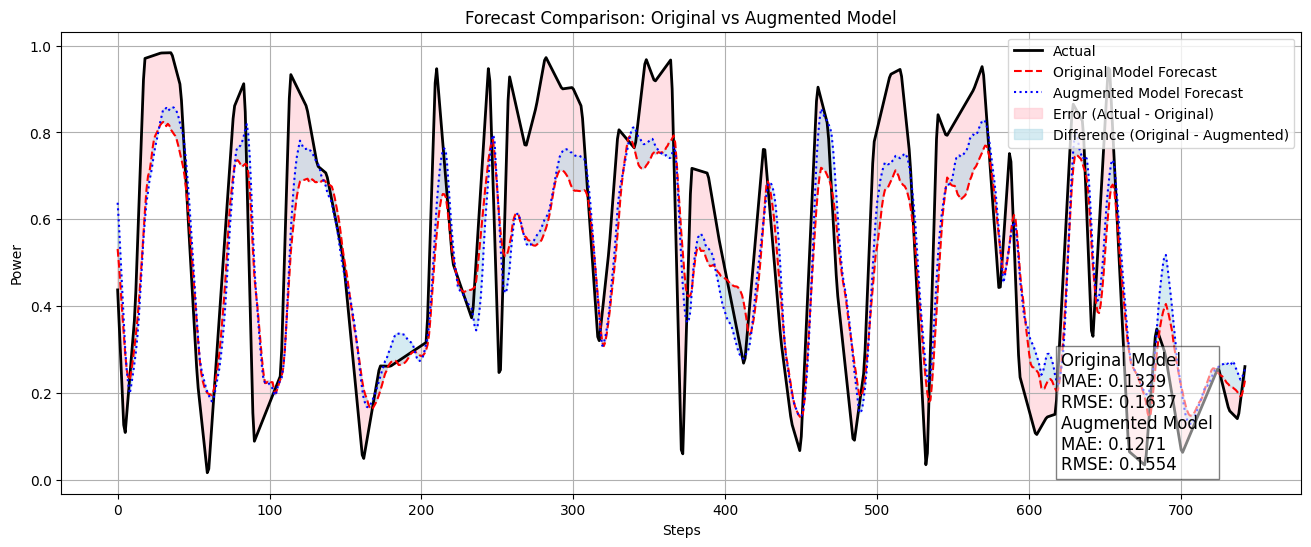

Original Model - MSE: 0.0124, MAE: 0.0893, RMSE: 0.1114
Augmented Model - MSE: 0.0097, MAE: 0.0765, RMSE: 0.0987


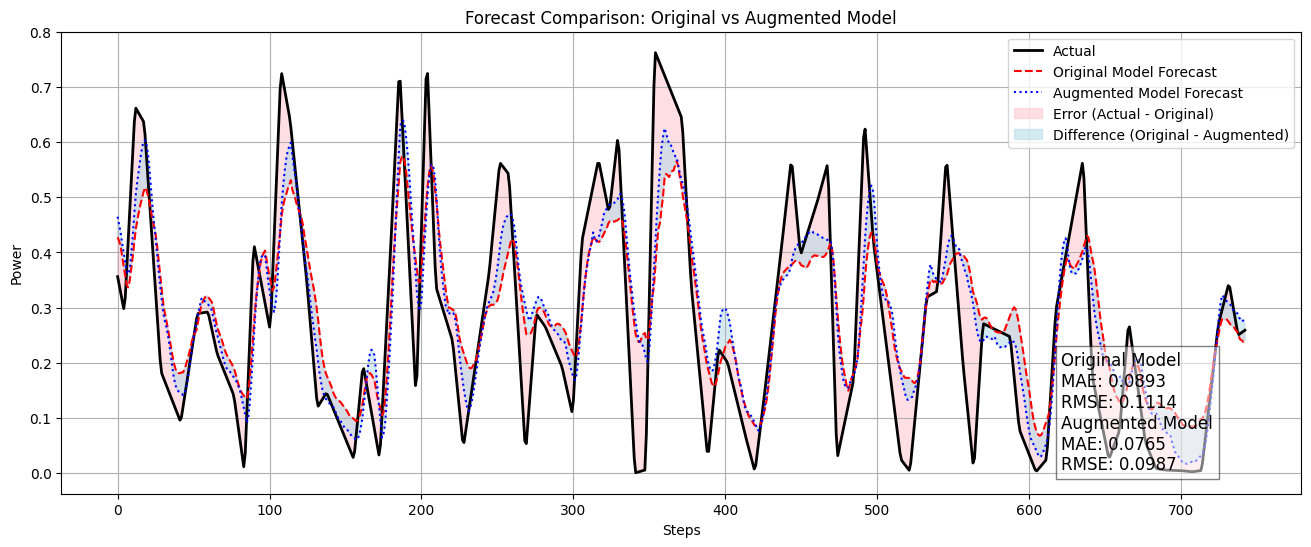

Original Model - MSE: 0.0389, MAE: 0.1657, RMSE: 0.1973
Augmented Model - MSE: 0.0327, MAE: 0.1521, RMSE: 0.1807


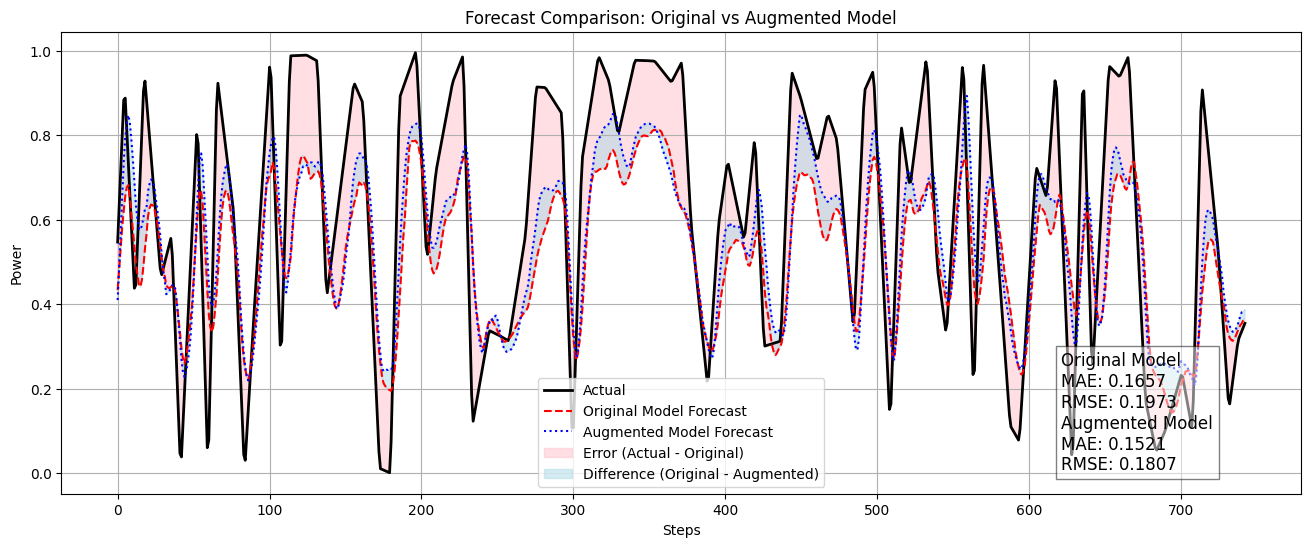

Original Model - MSE: 0.0177, MAE: 0.1068, RMSE: 0.1331
Augmented Model - MSE: 0.0156, MAE: 0.0998, RMSE: 0.1247


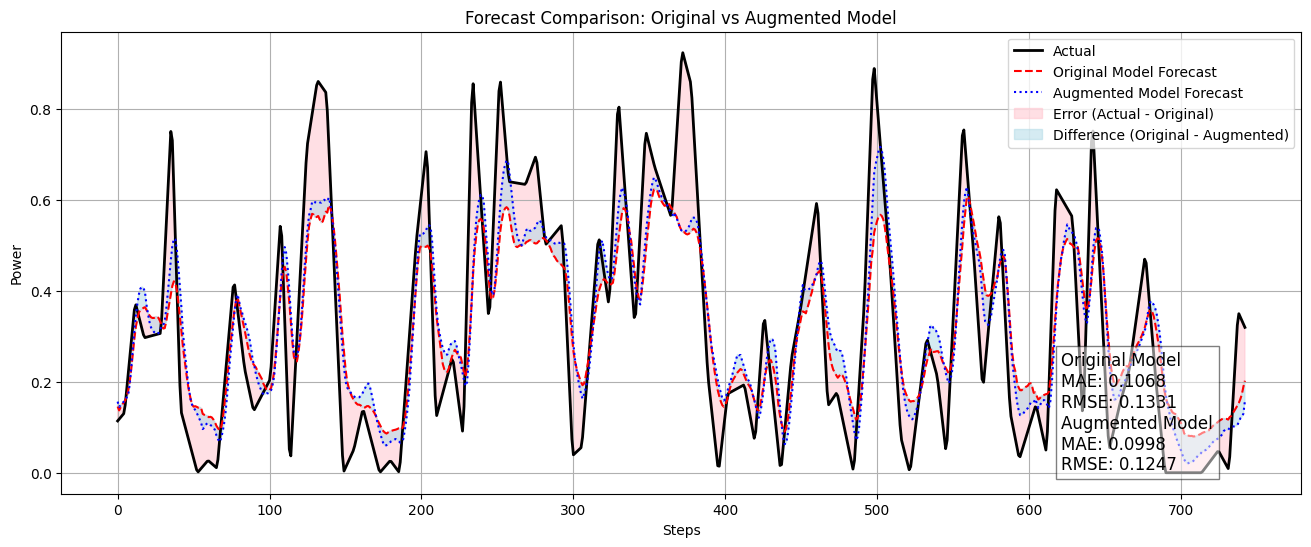

In [16]:
print("\nEvaluating PatchTST on test data...")
evaluate_two_models(model_orig=model_patchtst,model_aug=model_patchtst_aug, scaler= scaler_patchtst_aug, X_test=X_test, y_test= y_test,features= features, seq_len=seq_len, forecast_horizon=forecast_horizon, patch_len=patch_len, start_point=7991, end_point=8734)
evaluate_two_models(model_orig=model_patchtst,model_aug= model_patchtst_aug, scaler= scaler_patchtst_aug,X_test= X_test,y_test= y_test,features= features, seq_len=seq_len, forecast_horizon=forecast_horizon, patch_len=patch_len, start_point=16726, end_point=17469)
evaluate_two_models(model_orig=model_patchtst,model_aug= model_patchtst_aug, scaler= scaler_patchtst_aug, X_test=X_test,y_test= y_test,features= features,seq_len= seq_len, forecast_horizon=forecast_horizon, patch_len=patch_len, start_point=25461, end_point=26204)
evaluate_two_models(model_orig=model_patchtst,model_aug= model_patchtst_aug, scaler= scaler_patchtst_aug, X_test=X_test,y_test= y_test,features= features,seq_len= seq_len, forecast_horizon= forecast_horizon, patch_len=patch_len, start_point=34196, end_point=34939)
